In [282]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [283]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image (1102, 746, 3)


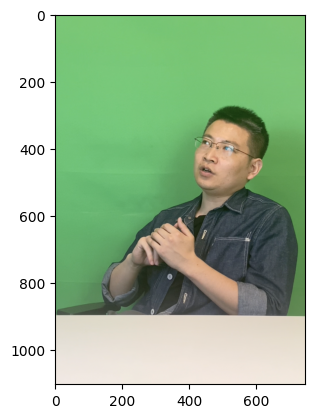

In [284]:
# load image

input_mean = 0.0
input_std = 1.0

img_path = "./align_img/fangzi.jpg"
image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # origin image in BGR
img = np.float32(image)

im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
scale = scale.to(device)


img -= (104, 117, 123) # mean substruction to reduce illumination changes
img = img.transpose(2, 0, 1)[None, :]

Batch_size = img.shape[0]

# show the origin image
# plt.imshow(image[:,:,::-1]/255)
plt.imshow(image[:,:,::-1]/255)

print("image",image.shape)

In [285]:
# input_shape2 = B*3*192*192

feed_img = torch.tensor(image,device=device).float()
feed_img = feed_img.permute(2,0,1).unsqueeze(0)

B,C,H,W = feed_img.shape
print("feed_img",feed_img.shape)

feed_img torch.Size([1, 3, 1102, 746])


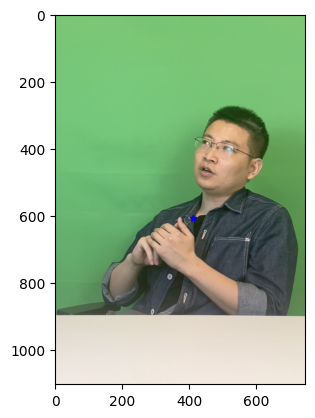

In [286]:
center = torch.tensor(feed_img.shape[-2:],device=device)

abstract_key_point = center*1.1
abstract_key_point_np = abstract_key_point.cpu().numpy()/2
plt.imshow(feed_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])
plt.scatter(abstract_key_point_np[1], abstract_key_point_np[0], c='b',  s=20, marker='*')

In [287]:
abstract_key_point

tensor([1212.2001,  820.6000], device='cuda:0')

In [288]:
abstract_key_point_np

array([606.10004, 410.30002], dtype=float32)

# 把函数单独拆出来debug用

In [289]:
(abstract_key_point - center)/center

tensor([0.1000, 0.1000], device='cuda:0')

In [290]:
# (grid - abstract_key_point_normalized.repeat(B,H,W,1)).shape
# affine_grid.shape
# Depth_coordinate

# 一步一步拆解的lawdnet

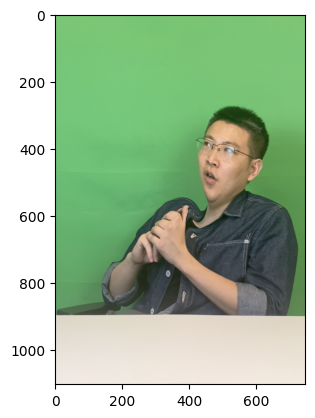

In [291]:
grid = F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:], torch.Size((B, C, H, W)))
#grid = (grid+1.0)*center.view(B,1,1,2)

abstract_key_point_normalized = (abstract_key_point - center)/center

dist = torch.norm(grid - abstract_key_point_normalized.repeat(B,1,1,1),dim=-1,keepdim=True)
k = 1e1
exp_minus_dist = torch.exp(-k*dist)
exp_minus_dist = torch.where(exp_minus_dist>1e-4,exp_minus_dist,torch.zeros_like(exp_minus_dist))

exp_minus_dist.max()

angle = torch.tensor(120.0,device=device)
             
theta = angle * torch.pi / 180.0

trans = 0*torch.tensor([20, 20],device=device)

trans_normalized = trans/center

scale = torch.tensor(1.5,device=device)

#rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]],device=device)

theta_grid = theta.repeat(B,H,W,1)*exp_minus_dist

rotation_matrix_grid = torch.cat([torch.cos(theta_grid), torch.sin(theta_grid), -torch.sin(theta_grid), torch.cos(theta_grid)], dim=-1).view(B,H,W,2,2)

trans_grid = trans_normalized.repeat(B,H,W,1)*exp_minus_dist

scale_grid = (scale.repeat(B,H,W,1)*exp_minus_dist)/2+1

affine_grid = rotation_matrix_grid.matmul(((grid - abstract_key_point_normalized.repeat(B,H,W,1))*scale_grid).unsqueeze(-1)).squeeze(-1)+abstract_key_point_normalized.repeat(B,H,W,1)+trans_grid

affine_img = F.grid_sample(feed_img, affine_grid)

plt.imshow(affine_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])


In [292]:
def standard_grid(size,batch_size=1,device='cuda'):
    """
    equivalent to 
    grid_trans = torch.eye(4).unsqueeze(0)
    F.affine_grid(grid_trans[:,:3,:], torch.Size((1, 3, D,H,W)))
    but more efficient and flexible

    size: (H,W) or (D,H,W)

    return: (B,H,W,2) or (B,D,H,W,3)

    """

    dim = len(size)

    axis = []
    for i in size:
        tmp = torch.linspace(-1+1/i, 1-1/i, i, device=device)
        
        axis.append(tmp)
    
    grid = torch.stack(torch.meshgrid(axis), dim=-1)

    grid = torch.flip(grid, dims=[-1]).contiguous()

    batch_grid = grid.unsqueeze(0).repeat((batch_size,)+(1,)*(dim+1))

    return batch_grid


# 这个函数不运行 不知道放着干嘛

In [293]:
class LocalAffineWarp(nn.Module):
    '''
    Local Affine Warping by Layers, invented by Yihao Luo,
    which is a generalization of Spatial Transformer Network,
    allowing local affine transformation smoothly on key points
    instead of global affine transformation
    
    input_shape: B*C*H*W
    para_code_shape: B*para_ch, 
        used to generate the parameters of local affine transformation
        though some simple net layers
    num_kpoints: number of key points, N
    feature_ch: number of channels of input images, C
    '''
    def __init__(self, para_ch=1024, num_kpoints=5, feature_ch=3, standard_grid_size=(20,20)):
        super(LocalAffineWarp, self).__init__()
        self.para_ch = para_ch
        self.num_kpoints = num_kpoints
        self.feature_ch = feature_ch
        self.commn_linear = nn.Sequential(
            nn.Linear(para_ch, para_ch),
            nn.ReLU()
        )

        self.kpoints_normalized_layer = nn.Sequential(
                nn.Linear(para_ch, 2 * num_kpoints * feature_ch),
                nn.Tanh()
            )

        self.similarity_params_layer = nn.Sequential(
                nn.Linear(para_ch, 4 * num_kpoints * feature_ch),
                nn.Tanh()
            )

        self.radius_layer = nn.Sequential(
                nn.Linear(para_ch, num_kpoints * feature_ch),
                nn.Sigmoid()
            )
            
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        self.stander_grid = standard_grid(standard_grid_size)

    def forward(self, feature_map, para_code):

        B,C,H,W = feature_map.shape

        para_code = self.commn_linear(para_code)

        kpoints_normalized = self.kpoints_normalized_layer(para_code).view(B, self.num_kpoints, self.feature_ch, 2)

        radius = self.radius_layer(para_code).view(B, self.num_kpoints, self.feature_ch, 1)

        similarity_params = self.similarity_params_layer(para_code).view(B, self.num_kpoints, self.feature_ch, 4)

        warped_feature_map =  self.local_similarity_warping_by_layers(feature_map, kpoints_normalized, radius,similarity_params)

        return warped_feature_map

    def local_similarity_warping_by_layers(self, source_img, kpoints_normalized, radius, similarity_params):
        '''
        source_img : B*C*H*W
        kpoints : B*N*C*2
        radius : B*N*C*1
        similarity_params : B*N*C*4
        '''
        print('source_img.shape:',source_img.shape)
        print('kpoints_normalized:',kpoints_normalized)
        print('radius:',radius)
        print('similarity_params:',similarity_params)
        

        B,C,H,W = source_img.shape
        device = source_img.device

        # regard the channel as the Depth of layers
        Depth_coordinate = torch.linspace(-1+1/C,1-1/C,C,device=device)

        N = kpoints_normalized.shape[1]

        H0, W0 = self.stander_grid.shape[-3:-1]

        grid_identity = self.stander_grid.unsqueeze(0).unsqueeze(0).repeat(1,N,C,1,1,1).unsqueeze(-2)# B*N*H*W*1*2

        offset_grid = grid_identity - kpoints_normalized.view(B,N,C,1,1,1,2)# B*N*C*H0*W0*1*2

        dist_grid = torch.norm(offset_grid,dim=-1) # B*N*C*H0*W0*1
        
        exp_minus_dist_grid = torch.exp(- dist_grid/(radius.view(B,N,C,1,1,1)))# B*N*C*H0*W0*1 origin
        # exp_minus_dist_grid = torch.exp(- dist_grid)
        print("调用最上面的law类的forward函数")

        scale_grid = (similarity_params[:,:,:,0:1]+1).view(B,N,C,1,1,1).repeat(1,1,1,H0,W0,1)*exp_minus_dist_grid+(1-exp_minus_dist_grid)*1.0
        
        angle_grid = (similarity_params[:,:,:,1:2]*torch.pi).view(B,N,C,1,1,1).repeat(1,1,1,H0,W0,1)*exp_minus_dist_grid

        trans_grid = similarity_params[:,:,:,-2:].view(B,N,C,1,1,2).repeat(1,1,1,H0,W0,1)*exp_minus_dist_grid

        Depth_coordinate = Depth_coordinate.view(1,C,1,1,1).repeat(B,1,H,W,1)

        rotation_matrix_grid = torch.cat([torch.cos(angle_grid), torch.sin(angle_grid), -torch.sin(angle_grid), torch.cos(angle_grid)], dim=-1).view(B,N,C,H0,W0,2,2)

        grid_warped_2d = scale_grid*(offset_grid.matmul(rotation_matrix_grid.transpose(-1,-2))).view(B,N,C,H0,W0,2) + trans_grid + kpoints_normalized.view(B,N,C,1,1,2)

        soft_max_weights = F.softmax(exp_minus_dist_grid,dim=1) # B*N*C*H*W*1

        grid_warped_2d = (grid_warped_2d*soft_max_weights).sum(dim=1) # B*C*H*W*2

        grid_warped_2d = grid_warped_2d.transpose(-1,-2).permute(0,1,4,2,3).contiguous().view(B,C*2,H0,W0)

        grid_warped_2d = transforms.Resize((H,W))(grid_warped_2d).to(device)


        # print('Depth_coordinate.shape:',Depth_coordinate.shape)
        # print('grid_warped_2d.shape:',grid_warped_2d.shape)

        grid_warped_2d = transforms.Resize((H,W))(grid_warped_2d).to(device)

        grid_warped_2d = grid_warped_2d.view(B,C,2,H,W).permute(0,1,3,4,2)

        grid_warped_3d = torch.cat([grid_warped_2d,Depth_coordinate],dim=-1)

        ### grid 
        warped_img = F.grid_sample(source_img.unsqueeze(1), grid_warped_3d)  # B*1*C*H*W

        return warped_img.squeeze(1)



In [294]:
# law1 = LocalAffineWarp(para_ch=25, num_kpoints=5, feature_ch=236).to(device)

# para_code = torch.randn(1,25,device=device)
# feed_img = torch.randn(1,236,320,190,device=device)

# law1.forward(feed_img,para_code).shape




In [295]:
standard_grid((20,20)).shape


torch.Size([1, 20, 20, 2])

In [296]:
source_img = feed_img
print('source_img.shape:',source_img.shape)

kpoints_normalized = torch.tensor([[0.1,-0.2],[-0.6,0.7],[0.1,0.1]],device=device).view(1,-1,2)
print('kpoints_normalized.shape:',kpoints_normalized.shape)

radius = torch.tensor([[0.1, 0.2, 0.3]],device=device).view(1,-1,1)
print('radius.shape:',radius.shape)

similarity_params = torch.tensor([[[1.0,-2.0,0.0,0.0],[0.8,2.0,0.0,0.0],[1.5,0.0,0.2,-0.1]]],device=device)
print('similarity_params.shape:',similarity_params.shape)

# warped_img = local_similarity_warping_aligned(source_img, kpoints_normalized, radius, similarity_params)

# plt.imshow(warped_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])


source_img.shape: torch.Size([1, 3, 1102, 746])
kpoints_normalized.shape: torch.Size([1, 3, 2])
radius.shape: torch.Size([1, 3, 1])
similarity_params.shape: torch.Size([1, 3, 4])


#  真正调用的函数

In [304]:
def local_similarity_warping_by_layers(source_img, kpoints_normalized, radius, similarity_params):
    '''
    source_img : B*C*H*W
    kpoints : B*N*C*2
    radius : B*N*C*1
    similarity_params : B*N*C*4
    '''

    B,C,H,W = source_img.shape
    device = source_img.device
    center = torch.tensor([H/2,W/2],device=device)

    # regard the channel as the Depth of layers
    Depth_coordinate = torch.linspace(-1+1/C,1-1/C,C,device=device)
    print('Depth_coordinate.shape:',Depth_coordinate.shape)
    print('Depth_coordinate:',Depth_coordinate)

    N = kpoints_normalized.shape[1]

    grid_identity = F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:], torch.Size((B, N, H, W))) # B*H*W*2

 
    grid_identity = grid_identity.view(B,1,1,H,W,2).repeat(1,N,C,1,1,1).unsqueeze(-2)# B*N*H*W*1*2
    print("grid_identity:",grid_identity.shape) #grid_identity: torch.Size([1, 2, 3, 1102, 746, 1, 2])

    
    offset_grid = grid_identity - kpoints_normalized.view(B,N,C,1,1,1,2)# B*N*C*H*W*1*2

    
    
    dist_grid = torch.norm(offset_grid,dim=-1) # B*N*C*H*W*1
    
    exp_minus_dist_grid = torch.exp(- dist_grid/(radius.view(B,N,C,1,1,1)))# B*N*C*H*W*1
    # exp_minus_dist_grid = torch.exp(- dist_grid)


    scale_grid = similarity_params[:,:,:,0:1].view(B,N,C,1,1,1).repeat(1,1,1,H,W,1)*exp_minus_dist_grid+(1-exp_minus_dist_grid)*1.0
    angle_grid = similarity_params[:,:,:,1:2].view(B,N,C,1,1,1).repeat(1,1,1,H,W,1)*exp_minus_dist_grid
    trans_grid = similarity_params[:,:,:,-2:].view(B,N,C,1,1,2).repeat(1,1,1,H,W,1)*exp_minus_dist_grid

    Depth_coordinate = Depth_coordinate.view(1,C,1,1,1).repeat(B,1,H,W,1)

    rotation_matrix_grid = torch.cat([torch.cos(angle_grid), torch.sin(angle_grid), -torch.sin(angle_grid), torch.cos(angle_grid)], dim=-1).view(B,N,C,H,W,2,2)

    grid_warped_2d = scale_grid*(offset_grid.matmul(rotation_matrix_grid.transpose(-1,-2))).view(B,N,C,H,W,2) + trans_grid + kpoints_normalized.view(B,N,C,1,1,2)
    # kpoints_normalized.view(B,N,C,1,1,2)

    soft_max_weights = F.softmax(exp_minus_dist_grid,dim=1) # B*N*C*H*W*1

    grid_warped_2d = (grid_warped_2d*soft_max_weights).sum(dim=1) # B*C*H*W*2

    print('Depth_coordinate.shape:',Depth_coordinate.shape)
    print('grid_warped_2d.shape:',grid_warped_2d.shape)


    grid_warped_3d = torch.cat([grid_warped_2d,Depth_coordinate],dim=-1)



    print('grid_warped_3d.shape:',grid_warped_3d.shape)

    ### grid 
    # luoyihao
    warped_img = F.grid_sample(source_img.unsqueeze(1), grid_warped_3d)  # B*1*C*H*W
    print("source_img.unsqueeze(1).shape:",source_img.unsqueeze(1).shape)
    print("warped_img.shape",warped_img.shape)

    # dengjunli
    flattened_img = source_img.view(B*C, 1, H, W)
    print("flattened_img.shape",flattened_img.shape)
    flattened_grid = grid_warped_2d.view(B*C,H,W,2)
    warped_img = F.grid_sample(flattened_img,flattened_grid).view(B,C,H,W)

    return warped_img.squeeze(1)

# 测试上面的函数


source_img.shape: torch.Size([1, 3, 1102, 746])
kpoints_normalized.shape: torch.Size([1, 2, 3, 2])
radius.shape: torch.Size([1, 2, 3, 1])
similarity_params.shape: torch.Size([1, 2, 3, 4])
Depth_coordinate.shape: torch.Size([3])
Depth_coordinate: tensor([-0.6667,  0.0000,  0.6667], device='cuda:0')
grid_identity: torch.Size([1, 2, 3, 1102, 746, 1, 2])
Depth_coordinate.shape: torch.Size([1, 3, 1102, 746, 1])
grid_warped_2d.shape: torch.Size([1, 3, 1102, 746, 2])
grid_warped_3d.shape: torch.Size([1, 3, 1102, 746, 3])
source_img.unsqueeze(1).shape: torch.Size([1, 1, 3, 1102, 746])
warped_img.shape torch.Size([1, 1, 3, 1102, 746])


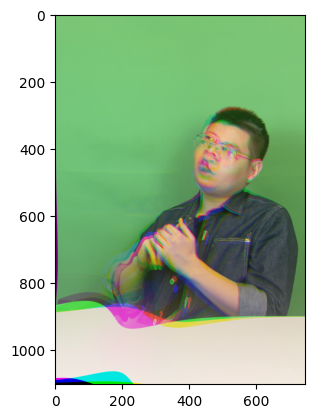

In [298]:
num_kpoints = 2

channels = 3

source_img = feed_img
print('source_img.shape:',source_img.shape)

kpoints_normalized = torch.tensor([[[0.1,-0.2],[-0.6,0.7]],[[0.2,-0.6],[-0.2,0.5]],[[0.3,-0.2],[-0.3,0.9]]],device=device).view(1,num_kpoints,channels,2)
print('kpoints_normalized.shape:',kpoints_normalized.shape)

radius = torch.tensor([[[0.1,0.2]]]*channels,device=device).view(1,num_kpoints,channels,1)
print('radius.shape:',radius.shape)

similarity_params = torch.tensor([[[1.0,2.0,0.0,0.0],[0.8,2,0.0,0.0]]]*channels,device=device).view(1,num_kpoints,channels,4)
print('similarity_params.shape:',similarity_params.shape)
# 调用单个函数
warped_img = local_similarity_warping_by_layers(source_img, kpoints_normalized, radius, similarity_params)

plt.imshow(warped_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])

In [299]:
def standard_grid(size,batch_size=1,device='cuda'):
    """
    equivalent to 
    grid_trans = torch.eye(4).unsqueeze(0)
    F.affine_grid(grid_trans[:,:3,:], torch.Size((1, 3, D,H,W)))
    but more efficient and flexible

    size: (H,W) or (D,H,W)

    return: (B,H,W,2) or (B,D,H,W,3)

    """

    dim = len(size)

    axis = []
    for i in size:
        tmp = torch.linspace(-1+1/i, 1-1/i, i, device=device)
        
        axis.append(tmp)
    
    grid = torch.stack(torch.meshgrid(axis), dim=-1)

    grid = torch.flip(grid, dims=[-1]).contiguous()

    batch_grid = grid.unsqueeze(0).repeat((batch_size,)+(1,)*(dim+1))

    return batch_grid

In [311]:
grid_identity = standard_grid((1102,746),1,device=device)
print("grid_identity.shape:",grid_identity.shape)
print("grid_identity:",grid_identity)


grid = F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:], torch.Size((B, C, H, W)))
print("grid:",grid.shape)
print("grid",grid)



grid_identity.shape: torch.Size([1, 1102, 746, 2])
grid_identity: tensor([[[[-0.9987, -0.9991],
          [-0.9960, -0.9991],
          [-0.9933, -0.9991],
          ...,
          [ 0.9933, -0.9991],
          [ 0.9960, -0.9991],
          [ 0.9987, -0.9991]],

         [[-0.9987, -0.9973],
          [-0.9960, -0.9973],
          [-0.9933, -0.9973],
          ...,
          [ 0.9933, -0.9973],
          [ 0.9960, -0.9973],
          [ 0.9987, -0.9973]],

         [[-0.9987, -0.9955],
          [-0.9960, -0.9955],
          [-0.9933, -0.9955],
          ...,
          [ 0.9933, -0.9955],
          [ 0.9960, -0.9955],
          [ 0.9987, -0.9955]],

         ...,

         [[-0.9987,  0.9955],
          [-0.9960,  0.9955],
          [-0.9933,  0.9955],
          ...,
          [ 0.9933,  0.9955],
          [ 0.9960,  0.9955],
          [ 0.9987,  0.9955]],

         [[-0.9987,  0.9973],
          [-0.9960,  0.9973],
          [-0.9933,  0.9973],
          ...,
          [ 0.9933,  0.997

/home/dengjunli/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# 复制到文章里用的,used


In [300]:
class LocalAffineWarp(nn.Module):
    '''
       Local Affine Warping by Layers
    '''
    def __init__(self, para_ch=1024, num_kpoints=5, feature_ch=3):
        super(LocalAffineWarp, self).__init__()
        self.para_ch = para_ch
        self.num_kpoints = num_kpoints
        self.feature_ch = feature_ch
        self.commn_linear = nn.Sequential(
            nn.Linear(para_ch, para_ch),
            nn.ReLU()
        )

        self.kpoints_normalized_layer = nn.Sequential(
                nn.Linear(para_ch, 2 * num_kpoints * feature_ch),
                nn.Tanh()
            )

        self.similarity_params_layer = nn.Sequential(
                nn.Linear(para_ch, 4 * num_kpoints * feature_ch),
                nn.Tanh()
            )

        self.radius_layer = nn.Sequential(
                nn.Linear(para_ch, num_kpoints * feature_ch),
                nn.Sigmoid()
            )
            
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, feature_map, para_code):

        B,C,H,W = feature_map.shape

        
        para_code = self.commn_linear(para_code)

        kpoints_normalized = self.kpoints_normalized_layer(para_code).view(B, self.num_kpoints, self.feature_ch, 2)

        radius = self.radius_layer(para_code).view(B, self.num_kpoints, self.feature_ch, 1)

        similarity_params = self.similarity_params_layer(para_code).view(B, self.num_kpoints, self.feature_ch, 4)

        warped_feature_map =  self.local_similarity_warping_by_layers(feature_map, kpoints_normalized, radius,similarity_params)

        return warped_feature_map

    def local_similarity_warping_by_layers(self,source_img, kpoints_normalized, radius, similarity_params):
        '''
        source_img : B*C*H*W
        kpoints : B*N*C*2
        radius : B*N*C*1
        similarity_params : B*N*C*4
        '''
        print('source_img.shape:',source_img.shape)
        print('kpoints_normalized.shape:',kpoints_normalized.shape)
        print('radius.shape:',radius.shape)
        print('similarity_params.shape:',similarity_params.shape)

        print('kpoints_normalized:',kpoints_normalized)
        print('radius:',radius)
        # print('similarity_params:',similarity_params)

        B,C,H,W = source_img.shape

        device = source_img.device

        center = torch.tensor([H/2,W/2],device=device)

        # regard the channel as the Depth of layers
        Depth_coordinate = torch.linspace(-1+1/C,1-1/C,C,device=device)

        N = kpoints_normalized.shape[1]

        grid_identity = standard_grid((H,W),B,device=device) # B*H*W*2
        #F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:], torch.Size((B, N, H, W))) # B*H*W*2

    
        grid_identity = grid_identity.view(B,1,1,H,W,2).repeat(1,N,C,1,1,1).unsqueeze(-2)# B*N*H*W*1*2

        
        offset_grid = grid_identity - kpoints_normalized.view(B,N,C,1,1,1,2)# B*N*C*H*W*1*2

        
        
        dist_grid = torch.norm(offset_grid,dim=-1) # B*N*C*H*W*1
        
        exp_minus_dist_grid = torch.exp(- dist_grid/(radius.view(B,N,C,1,1,1)))# B*N*C*H*W*1


        scale_grid = (similarity_params[:,:,:,0:1]+1).view(B,N,C,1,1,1).repeat(1,1,1,H,W,1)*exp_minus_dist_grid+(1-exp_minus_dist_grid)*1.0
        
        angle_grid = (similarity_params[:,:,:,1:2]*torch.pi).view(B,N,C,1,1,1).repeat(1,1,1,H,W,1)*exp_minus_dist_grid

        trans_grid = similarity_params[:,:,:,-2:].view(B,N,C,1,1,2).repeat(1,1,1,H,W,1)*exp_minus_dist_grid

        Depth_coordinate = Depth_coordinate.view(1,C,1,1,1).repeat(B,1,H,W,1)

        rotation_matrix_grid = torch.cat([torch.cos(angle_grid), torch.sin(angle_grid), -torch.sin(angle_grid), torch.cos(angle_grid)], dim=-1).view(B,N,C,H,W,2,2)

        grid_warped_2d = scale_grid*(offset_grid.matmul(rotation_matrix_grid.transpose(-1,-2))).view(B,N,C,H,W,2) + trans_grid + kpoints_normalized.view(B,N,C,1,1,2)

        soft_max_weights = F.softmax(exp_minus_dist_grid,dim=1) # B*N*C*H*W*1

        grid_warped_2d = (grid_warped_2d*soft_max_weights).sum(dim=1) # B*C*H*W*2

        # print('Depth_coordinate.shape:',Depth_coordinate.shape)
        # print('grid_warped_2d.shape:',grid_warped_2d.shape)


        grid_warped_3d = torch.cat([grid_warped_2d,Depth_coordinate],dim=-1) 


        ### grid 
        
        warped_img = F.grid_sample(source_img.unsqueeze(1), grid_warped_3d)  # B*1*C*H*W

        return warped_img.squeeze(1)

# 验证lawdnet这个类是否可以正常运行

source_img.shape: torch.Size([1, 3, 1102, 746])
kpoints_normalized.shape: torch.Size([1, 5, 3, 2])
radius.shape: torch.Size([1, 5, 3, 1])
similarity_params.shape: torch.Size([1, 5, 3, 4])
kpoints_normalized: tensor([[[[ 0.0564, -0.0911],
          [-0.0372, -0.1350],
          [ 0.1461,  0.0390]],

         [[-0.2110, -0.1715],
          [-0.0508,  0.1715],
          [ 0.0827, -0.1208]],

         [[ 0.1048, -0.0863],
          [ 0.3125, -0.2971],
          [-0.0208,  0.2424]],

         [[ 0.2960,  0.0292],
          [ 0.0137,  0.0729],
          [-0.0796,  0.1075]],

         [[-0.0842, -0.2395],
          [ 0.1914,  0.1478],
          [-0.0962,  0.0812]]]], device='cuda:0', grad_fn=<ViewBackward0>)
radius: tensor([[[[0.4798],
          [0.5093],
          [0.4988]],

         [[0.5262],
          [0.5339],
          [0.5222]],

         [[0.5961],
          [0.4234],
          [0.3928]],

         [[0.5026],
          [0.5805],
          [0.4854]],

         [[0.4868],
          [0.

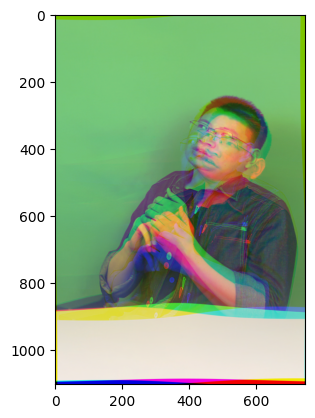

In [301]:
law1 = LocalAffineWarp()
law1.to(device)
warped_img = law1(feed_img,torch.randn(1,1024,device=device))

plt.imshow(warped_img[0].permute(1,2,0).detach().cpu().numpy().astype(np.uint8)[...,::-1])

##  aligned Warping

In [302]:
# warped_img = local_similarity_warping_by_layers(source_img, kpoints_normalized, radius, similarity_params)

In [303]:
# plt.imshow(warped_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])